In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from polyvore_dataset import categoryDataset
from sklearn import metrics
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%matplotlib inline

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])
img = Image.open('./cat_dog.png').convert('RGB')
img = transform(img)
img = img.unsqueeze(0)
img.requires_grad=True

In [3]:
model = models.resnet152(pretrained=True)
model.eval()
score = model(img).data.numpy()
print(np.argsort(score)[0][-5:])

[243 753 245 281 282]


In [4]:
gradients = None
# Register hook to the first layer
def hook_function(module, grad_in, grad_out):
    global gradients
    gradients = grad_in[0]
    
first_layer = list(model.modules())[1]
first_layer.register_backward_hook(hook_function)

In [5]:
"""
    Updates relu activation functions so that it only returns positive gradients
"""
def relu_hook_function(module, grad_in, grad_out):
    """
    If there is a negative gradient, changes it to zero
    """
    if isinstance(module, nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.0),)
# Loop through layers, hook up ReLUs with relu_hook_function
        
for module in model.modules():
    if isinstance(module, nn.ReLU):
        module.register_backward_hook(relu_hook_function)

In [6]:
out = model(img)
model.zero_grad()
one_hot = torch.FloatTensor(1, out.size()[-1]).zero_()
one_hot[0][243] = 1

out.backward(gradient=one_hot, retain_graph=True)

In [7]:
grad = gradients.data.numpy().squeeze()
grad = grad - grad.min()
grad /= grad.max()
grad = np.uint8(grad * 255).transpose(1, 2, 0)

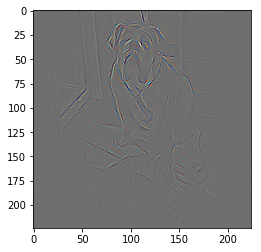

In [8]:
plt.imshow(grad)